In [1]:
import time

import re
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim
import spacy
import pickle

from sklearn.metrics import confusion_matrix
import keras
import numpy as np

import pandas as pd
import seaborn as sns

import IPython.display as ipd

import warnings
warnings.filterwarnings('ignore')

/home/yinjiarui27/miniconda3/lib/python3.9/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (5.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
2022-11-02 16:36:45.457477: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 16:36:45.585027: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 16:36:45.585047: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not

In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [2]:
import pandas as pd

# Import dataset

In [18]:
df = pd.read_csv('./df_english_labelled_verified.csv', encoding='latin1') 
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,is_english,label
0,1,3577f7a1-3394-4e77-813d-095a82cf8bcf,Kemar Richardson,https://play-lh.googleusercontent.com/a-/ACNPE...,Great,5.0,0.0,26.3.4,10/4/2022 20:32,NaN,NaN,True,POSITIVE
1,2,7c8c56d9-d8ad-47d4-b24b-5289aa4529ff,Tracy Dunn,https://play-lh.googleusercontent.com/a/ALm5wu...,good,5.0,0.0,26.4.3,10/4/2022 20:31,NaN,NaN,True,POSITIVE
2,3,80db804f-cccd-4b09-b690-abc12cbf0612,SG. Mugo. (Mugoz:),https://play-lh.googleusercontent.com/a-/ACNPE...,Good app,5.0,0.0,26.3.4,10/4/2022 20:30,NaN,NaN,True,POSITIVE
3,4,4ed35e90-0f45-4865-81c4-b3a6f2ea49f7,Mwansa Judy,https://play-lh.googleusercontent.com/a-/ACNPE...,Most amazing app,5.0,0.0,26.3.4,10/4/2022 20:29,NaN,NaN,True,POSITIVE
4,5,bd35bbe9-73c9-4e17-acaf-7aa1a71caed3,Muhammad Sajid,https://play-lh.googleusercontent.com/a-/ACNPE...,full Entertainment,4.0,0.0,25.9.4,10/4/2022 20:28,NaN,NaN,True,POSITIVE


In [4]:
df=df.astype(str)

In [19]:
df['label'].unique()

array(['POSITIVE', 'NEGATIVE', 'NEUTRAL', nan], dtype=object)

In [20]:
df.dropna()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,is_english,label
664,782,5904d57b-73a4-49d7-b056-79c3528dbfd9,james gallagher,https://play-lh.googleusercontent.com/a/ALm5wu...,I am currently having an issue where accounts ...,2.0,275.0,26.4.3,10/4/2022 13:05,"Hi, TikTok team will treat your suggestions wi...",8/11/2020 10:50,True,NEGATIVE
854,1009,0152c051-ee38-40a7-9e47-40fe4bdbdb97,Nathan Flatt,https://play-lh.googleusercontent.com/a-/ACNPE...,Its a great way to pass the time you can watch...,5.0,666.0,26.3.4,10/4/2022 10:21,"Hi, thanks for the high rating. TikTok team wi...",10/6/2020 11:18,True,POSITIVE
6258,8970,8200780f-87de-4369-af3a-2b20fdb4bbfe,Syeda Faiza Imtiaz,https://play-lh.googleusercontent.com/a-/ACNPE...,Its not opening since last night Whats the ma...,2.0,0.0,19.2.41,10/1/2022 4:23,"Hi,\r\n\r\nWe apologize for the inconvenience ...",8/9/2018 17:04,True,NEUTRAL
7145,9857,57fd022a-c143-46dd-a8fa-283dd41ca818,ýýýýýýýý,https://play-lh.googleusercontent.com/a-/ACNPE...,ýýýýýý ýýýýýý,5.0,70.0,19.5.43,9/30/2022 20:51,ýýýýýýýýýýýýýý ýýýýýýýýýý ýýýýýý ýýýýýýýýýýýýý...,9/25/2020 13:27,False,NEUTRAL
9001,11713,63794883-27b5-4ce2-beb4-30fcc9f3c648,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,its bad i cant enter my name been struggling w...,4.0,0.0,25.8.5,9/30/2022 0:42,"Hi, \r\n\r\nThanks for your valuable feedback!...",3/5/2019 14:53,True,NEGATIVE
10918,13630,a18a637c-4571-4775-a615-f63c0ff558c8,Tank,https://play-lh.googleusercontent.com/a-/ACNPE...,when will tiktok get Black mode for android,1.0,0.0,26.3.4,9/29/2022 3:12,"Hi, \r\n\r\nWe apologize for the inconvenience...",12/6/2018 15:20,True,NEUTRAL
11393,14105,27d33af8-58a0-4215-84a0-5939997ca4ce,May May,https://play-lh.googleusercontent.com/a-/ACNPE...,Is the dislike button in the comments really n...,2.0,196.0,26.3.3,9/28/2022 23:13,"Hi, \r\n\r\nThanks for your valuable feedback!...",3/11/2019 13:56,True,NEUTRAL
13365,16077,05887011-bb96-450c-8bac-f7493242528a,Greg Rekounas,https://play-lh.googleusercontent.com/a-/ACNPE...,Ok That response I wasnt making a suggestion I...,1.0,1178.0,26.3.3,9/28/2022 1:28,"Hi, thanks for the great suggestions! We will ...",9/26/2022 14:39,True,POSITIVE
15397,18109,e691bee4-3187-4b26-a746-758623589fe2,Tamikia Lotongo,https://play-lh.googleusercontent.com/a-/ACNPE...,An epic way to learn new stuff find out cool h...,5.0,115.0,26.0.3,9/27/2022 4:57,"Hi, thanks for the high rating. TikTok team wi...",6/12/2021 16:55,True,POSITIVE
20474,23186,a970f73e-1cb7-4ad0-9429-539ea8cdb9d5,Poppy Jones,https://play-lh.googleusercontent.com/a/ALm5wu...,Its fun if you make fun,5.0,292.0,26.2.3,9/25/2022 2:50,"Hi, thanks for the high rating, TikTok team wi...",3/18/2020 16:49,True,POSITIVE


In [21]:
df.groupby('label').nunique()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,is_english
label,,,,,,,,,,,,
NEGATIVE,5381,5381,5329,5366,5127,5,86,183,4886,7,7,2
NEUTRAL,13727,13727,13188,13697,10363,5,30,246,10917,6,6,2
POSITIVE,34564,34564,33240,34511,18441,5,92,292,20556,8,11,2


### Exclude first 1000 data
First 1000 data is used as test dataset

In [23]:
train = df[['content','label']].tail(len(df)-1000)
train.head()

,content,label
1000,It blows my mind how so many people are ok wit...,NEGATIVE
1001,Im famous Just as soon as people see my videos...,POSITIVE
1002,Really need to be able to block certain sounds...,NEUTRAL
1003,Good stuff very interesting a lot of intellige...,POSITIVE
1004,I hate this app because one day when I was goi...,NEGATIVE


### Drop empty content

In [9]:
train["content"].isnull().sum()

0

In [35]:
train.dropna()

,content,label
1000,It blows my mind how so many people are ok wit...,NEGATIVE
1001,Im famous Just as soon as people see my videos...,POSITIVE
1002,Really need to be able to block certain sounds...,NEUTRAL
1003,Good stuff very interesting a lot of intellige...,POSITIVE
1004,I hate this app because one day when I was goi...,NEGATIVE
...,...,...
53665,This should get a 5 because peopple like dancing,POSITIVE
53666,Its a very good app but suddenly I was unable ...,POSITIVE
53667,Nice,POSITIVE
53668,Good,NEUTRAL


# Clean Dataset

In [10]:
def clean_data(data):
    #combine lines into a single line
    data = re.sub('\s+', ' ', data)

    #remove single quotes
    data = re.sub("\'", "", data)
        
    return data


def sent_to_words(sentences):
    for sentence in sentences:
        #remove punctuations from sentences by setting deaccent() to True
        #this function also tokenizes sentences to words
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        

def detokenize(text):
    #treebank tokenizer combines tokenized words into sentence
    return TreebankWordDetokenizer().detokenize(text)

### Remove new lines & single quotes

In [11]:
temp = []
#split review content sentences to list
data_to_list = train['content'].values.tolist()
for i in range(len(data_to_list)):
    temp.append(clean_data(data_to_list[i]))
list(temp[:5])

['It blows my mind how so many people are ok with their personal data and information being shared with a data corporation in China Tik Tok executives couldnt even give an honest answer about this during testimony to Congress They just kept repeating the same thing over and over again Im sure a representative from the company will try to down play this but after watching the video the truth is clear and evident Deleted this app off my phone',
 'Im famous Just as soon as people see my videos Lol',
 'Really need to be able to block certain sounds thatd be much appreciated',
 'Good stuff very interesting a lot of intelligent people on there a lot of really stupid ones too but hey you get both sides of the opinion the dumb ones and the actual intelligent ones so its actually really informative good social media actually does what social media is supposed to do',
 'I hate this app because one day when I was going on it just said no Internet and there was Internet and I was so sick of this i

### Remove punctuation & accent mark

In [12]:
#tokenize sentences
data_words = list(sent_to_words(temp))

print(data_words[:10])
print(len(data_words))

[['it', 'blows', 'my', 'mind', 'how', 'so', 'many', 'people', 'are', 'ok', 'with', 'their', 'personal', 'data', 'and', 'information', 'being', 'shared', 'with', 'data', 'corporation', 'in', 'china', 'tik', 'tok', 'executives', 'couldnt', 'even', 'give', 'an', 'honest', 'answer', 'about', 'this', 'during', 'testimony', 'to', 'congress', 'they', 'just', 'kept', 'repeating', 'the', 'same', 'thing', 'over', 'and', 'over', 'again', 'im', 'sure', 'representative', 'from', 'the', 'company', 'will', 'try', 'to', 'down', 'play', 'this', 'but', 'after', 'watching', 'the', 'video', 'the', 'truth', 'is', 'clear', 'and', 'evident', 'deleted', 'this', 'app', 'off', 'my', 'phone'], ['im', 'famous', 'just', 'as', 'soon', 'as', 'people', 'see', 'my', 'videos', 'lol'], ['really', 'need', 'to', 'be', 'able', 'to', 'block', 'certain', 'sounds', 'thatd', 'be', 'much', 'appreciated'], ['good', 'stuff', 'very', 'interesting', 'lot', 'of', 'intelligent', 'people', 'on', 'there', 'lot', 'of', 'really', 'stupid

### Combine each sentence list to a big list

In [13]:
data = []
for i in range(len(data_words)):
    data.append(detokenize(data_words[i]))
print(data[:5])

['it blows my mind how so many people are ok with their personal data and information being shared with data corporation in china tik tok executives couldnt even give an honest answer about this during testimony to congress they just kept repeating the same thing over and over again im sure representative from the company will try to down play this but after watching the video the truth is clear and evident deleted this app off my phone', 'im famous just as soon as people see my videos lol', 'really need to be able to block certain sounds thatd be much appreciated', 'good stuff very interesting lot of intelligent people on there lot of really stupid ones too but hey you get both sides of the opinion the dumb ones and the actual intelligent ones so its actually really informative good social media actually does what social media is supposed to do', 'hate this app because one day when was going on it just said no internet and there was internet and was so sick of this is one of my favori

### Convert text to numpy array

In [14]:
data = np.array(data)

# Data encoding
#### One Hot Encoding: replace each word with vector of length |V|. Representation of words in sparse vector

['dog', 'cat', 'fish']

- 'dog': [1,0,0]. 
- 'cat': [0,1,0]
- 'fish': [0,0,1]

#### Word Embedding: replace each word with a vector that represents the word characteristic with float. Representation of words in dense vector

['dog', 'cat', 'table']

['animal', 'need-to-feed', 'authority', 'gender'] using 4d word embedding
- 'dog': [1.2, 1, 0.1, -1]
- 'cat': [1.3, 1, 0.05, -1]
- 'table': [-1, -1, 0, 0]

### Deep learning models converge easier with dense vectors than with sparse ones. We do not use one hot encoding here as we could have a very large vocabulary 

## Label encoding

Label each category:

- "POSITIVE": 2
- "NEGATIVE": 1
- "NEUTRAL": 0

In [15]:
labels = np.array(train['label'])
print(train['label'])
y = []
for i in range(len(labels)):
    if labels[i] == 'POSITIVE':
        y.append(2)
    if labels[i] == 'NEGATIVE':
        y.append(1)
    if labels[i] == 'NEUTRAL':
        y.append(0)
y = np.array(y)
labels = tf.keras.utils.to_categorical(y, 3, dtype="float32")
del y

1000     NEGATIVE
1001     POSITIVE
1002      NEUTRAL
1003     POSITIVE
1004     NEGATIVE
           ...   
53667    POSITIVE
53668     NEUTRAL
53669     NEUTRAL
53670    POSITIVE
53671     NEUTRAL
Name: label, Length: 52672, dtype: object


## Content encoding

In [16]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)
review = pad_sequences(sequences, maxlen=max_len)
print(review)

[[   0    0    0 ...  252    4  149]
 [   0    0    0 ...    4   29  409]
 [   0    0    0 ...   56   61 2081]
 ...
 [   0    0    0 ... 3783 3093 2617]
 [   0    0    0 ...  171   10  171]
 [   0    0    0 ...   25   25   25]]


In [17]:
print(labels)

[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


### Train-test split

In [18]:
#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(review, labels, test_size = 0.3, random_state=0)
print ("X_Train length: ", len(X_train), "\nX_Test length: ", len(X_test), 
       "\ny_train length: ", len(y_train), "\ny_test length: ", len(y_test))

X_Train length:  36870 
X_Test length:  15802 
y_train length:  36870 
y_test length:  15802


# Model building

RNN is widely used for nlp and text sentiment in neural networks. However, it is unable to handle "long term dependency"


For example, when the input sentence "The cat which sits on the fence has a tabby tail" contains a clause, RNN cannot differentiate whether the cat or the fence has a tabby tail. Therefore, Long Short Term Memory is introduced to tackle this issue


There are two gates in GRU: 
- update gate: decides whether information should be forgotten or stored from previous state
- reset gate: decides how much historical information to be forgotten

#### GRU has the ability to add and remove information to the cell states through gates

In [19]:
from sklearn import preprocessing
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import EarlyStopping

## Gated Recurrent Unit (GRU)

In [22]:
max_epochs = 100
batch_size = 256

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

model_GRU = Sequential()
model_GRU.add(layers.Embedding(max_words, 40, input_length=max_len))
model_GRU.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
model_GRU.add(layers.Dense(3,activation='softmax'))


model_GRU.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

start_time=time.time()
history = model_GRU.fit(X_train, y_train, 
                          epochs=max_epochs,
                          batch_size = 256,
                          validation_data=(X_test, y_test),
                          callbacks=[stop_early])
stop_time=time.time()
duration =stop_time-start_time

Epoch 1/100
274/274 [==============================] - 42s 145ms/step - loss: 0.5396 - accuracy: 0.7860 - val_loss: 0.3480 - val_accuracy: 0.8762
Epoch 2/100
274/274 [==============================] - 40s 145ms/step - loss: 0.2506 - accuracy: 0.9095 - val_loss: 0.2203 - val_accuracy: 0.9215
Epoch 3/100
274/274 [==============================] - 40s 147ms/step - loss: 0.1924 - accuracy: 0.9336 - val_loss: 0.1816 - val_accuracy: 0.9382
Epoch 4/100
274/274 [==============================] - 41s 150ms/step - loss: 0.1687 - accuracy: 0.9424 - val_loss: 0.1632 - val_accuracy: 0.9459
Epoch 5/100
274/274 [==============================] - 41s 148ms/step - loss: 0.1504 - accuracy: 0.9495 - val_loss: 0.1479 - val_accuracy: 0.9519
Epoch 6/100
274/274 [==============================] - 40s 147ms/step - loss: 0.1378 - accuracy: 0.9539 - val_loss: 0.1447 - val_accuracy: 0.9538
Epoch 7/100
274/274 [==============================] - 40s 145ms/step - loss: 0.1304 - accuracy: 0.9574 - val_loss: 0.1383 -

In [23]:
print("average time taken for each epoch: ", duration/43)

average time taken for each epoch:  38.776725696962934


### Accuracy & time plot

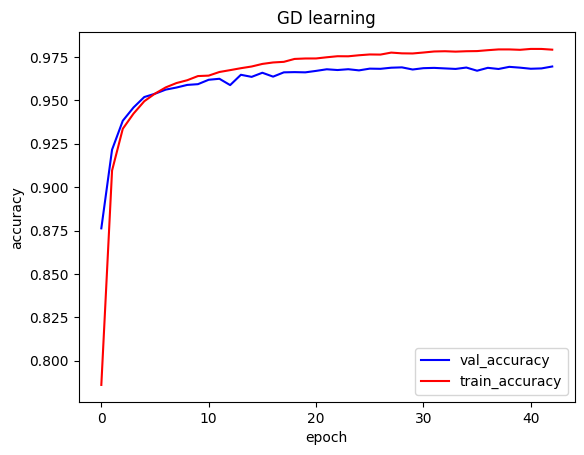

In [24]:
plt.plot(history.history['val_accuracy'], "-b")
plt.plot(history.history['accuracy'], "-r")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('GD learning')
plt.gca().legend(('val_accuracy','train_accuracy'))
plt.show()

Text(0.5, 1.0, 'GD learning')

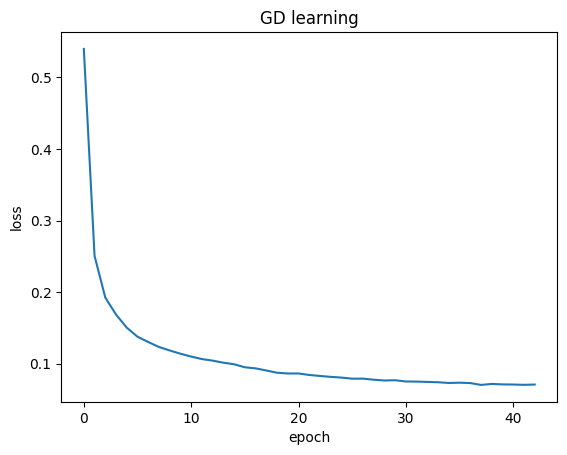

In [25]:
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('GD learning')

# Testing

In [26]:
test_loss, test_acc = model_GRU.evaluate(X_test, y_test, verbose=2)
print('Model accuracy: ',test_acc)

937/937 - 9s - loss: 0.1105 - accuracy: 0.9695 - 9s/epoch - 10ms/step
Model accuracy:  0.9694865345954895


## Testing with sample sentences

In [27]:
sequencePOS = tokenizer.texts_to_sequences(['i like the app will recommend to my friends'])
sequenceNEG = tokenizer.texts_to_sequences(['this app has been the worst , want my time back'])
sequenceNEU = tokenizer.texts_to_sequences(['i do not know how i feel about this app yet'])

predictions = {}
labels = []

test1 = pad_sequences(sequencePOS, maxlen=max_len)
test2 = pad_sequences(sequenceNEG, maxlen=max_len)
test3 = pad_sequences(sequenceNEU, maxlen=max_len)

prediction = model_GRU.predict(test1)
no_rep = np.argmax(prediction[0])
labels.append(no_rep)

prediction = model_GRU.predict(test2)
no_rep = np.argmax(prediction[0])
labels.append(no_rep)

prediction = model_GRU.predict(test3)
no_rep = np.argmax(prediction[0])
labels.append(no_rep)

predResults = []

for label in labels:
    if label == 0:
        predResults.append("NEUTRAL")
    elif label == 1:
        predResults.append("NEGATIVE")
    else:
        predResults.append("POSITIVE")
        
predictions['Positive sample'] = predResults[0]
predictions['Negative sample'] = predResults[1]
predictions['Neutral sample'] = predResults[2]

print(predictions)

1/1 [==============================] - 0s 17ms/step
{'Positive sample': 'POSITIVE', 'Negative sample': 'NEGATIVE', 'Neutral sample': 'NEUTRAL'}


### Save & load GRU model

In [28]:
model_GRU.save('saved_model/best_model')

INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


In [17]:
model = tf.keras.models.load_model('saved_model/best_model/')

2022-10-31 14:49:23.194617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Testing with 1000 data

In [18]:
test1000 = df[['content','label']].head(1000)
test1000.head()

,content,label
0,Great,POSITIVE
1,good,POSITIVE
2,Good app,POSITIVE
3,Most amazing app,POSITIVE
4,full Entertainment,POSITIVE


In [21]:
labels = []
predResults = []

for content in test1000['content']: 
    sequence = tokenizer.texts_to_sequences([content])
    test = pad_sequences(sequence, maxlen=max_len)

    prediction = model.predict(test)
    no_rep = np.argmax(prediction[0])
    labels.append(no_rep)

for label in labels:
    if label == 0:
        predResults.append("NEUTRAL")
    elif label == 1:
        predResults.append("NEGATIVE")
    else:
        predResults.append("POSITIVE")

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


In [35]:
test1000.groupby('label').size()

label
NEGATIVE    194
NEUTRAL     157
POSITIVE    649
dtype: int64

In [ ]:
test1000['predicted label'] = predResults

In [29]:
test1000.head(20)

,content,label,predicted label
0,Great,POSITIVE,POSITIVE
1,good,POSITIVE,POSITIVE
2,Good app,POSITIVE,POSITIVE
3,Most amazing app,POSITIVE,POSITIVE
4,full Entertainment,POSITIVE,POSITIVE
5,Nice app,POSITIVE,POSITIVE
6,Super and good app,POSITIVE,POSITIVE
7,TikTok warning and video views problem in my i...,NEGATIVE,NEGATIVE
8,Tiktok is a nice app,POSITIVE,NEGATIVE
9,Need my Tik tok open note,NEUTRAL,NEUTRAL


## Model Evaluation

In [30]:
correct = 0

for i in range(1000):
    if test1000['label'][i] == test1000['predicted label'][i]:
        correct+=1
print(correct)        

904


In [ ]:
true_positive = 0
false_positive = 0
false_negative = 0

for i in range(1000):
    if test1000['label'][i] == "POSITIVE" and test1000['predicted label'][i] == "POSITIVE":
        true_positive+=1

for j in range(1000):
    if test1000['label'][j] != "POSITIVE" and test1000['predicted label'][j] == "POSITIVE":
        false_positive+=1

for k in range(1000):
    if test1000['label'][k] != "NEGATIVE" and test1000['predicted label'][k] == "NEGATIVE":
        false_negative+=1

In [38]:
print("no. of true positive: ", true_positive)
print("no. of false positive: ", false_positive)
print("no. of false negative: ", false_negative)

no. of true positive:  610
no. of false positive:  88
no. of false negative:  43


In [33]:
print("prediction accurary: ", correct/1000)

prediction accurary:  0.904


In [27]:
predictions = model.predict(X_test)

937/937 [==============================] - 10s 10ms/step


# Unfolded VS K-folded Dataset

## Confusion matrix for unfolded dataset
### This is NOT a confusion matrix for 1000 test data

**y_test from train_test_split is used here

**This is to observe how the GRU model performs compared to the reuslts from the following k-fold experiment

In [28]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(predictions, decimals=0).argmax(axis=1))

<AxesSubplot: >

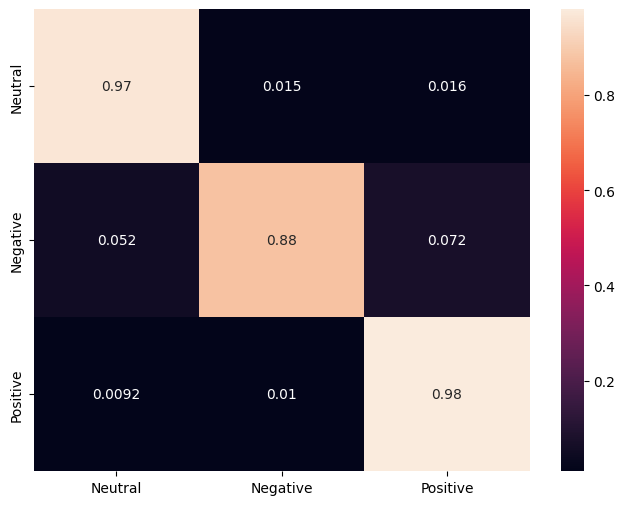

In [36]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 10})

# 5-fold Cross Validation

In [27]:
n_split=5
val_accuracy = {}
epoch_time = {}
curr_epoch_duration = []
curr_val_accuracy = []

for train_index,val_index in KFold(n_split).split(X_train):
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold,y_val_fold = y_train[train_index], y_train[val_index]

    start_time=time.time()

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    model_GRU_5fold = Sequential()
    model_GRU_5fold.add(layers.Embedding(max_words, 40, input_length=max_len))
    model_GRU_5fold.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
    model_GRU_5fold.add(layers.Dense(3,activation='softmax'))


    model_GRU_5fold.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

    start_time=time.time()
    history = model_GRU_5fold.fit(x_train_fold, y_train_fold, 
                              epochs=100,
                              batch_size = 256,
                              validation_data=(x_val_fold, y_val_fold),
                              callbacks=[stop_early])

    stop_time=time.time()
    duration =stop_time-start_time
    curr_epoch_duration.append(duration)

    validation = history.history['val_accuracy'][-1]
    curr_val_accuracy.append(validation)

Epoch 1/100
219/219 [==============================] - 27s 117ms/step - loss: 0.5946 - accuracy: 0.7619 - val_loss: 0.3474 - val_accuracy: 0.8727
Epoch 2/100
219/219 [==============================] - 26s 120ms/step - loss: 0.2824 - accuracy: 0.8978 - val_loss: 0.2501 - val_accuracy: 0.9105
Epoch 3/100
219/219 [==============================] - 27s 122ms/step - loss: 0.2217 - accuracy: 0.9221 - val_loss: 0.1994 - val_accuracy: 0.9281
Epoch 4/100
219/219 [==============================] - 28s 126ms/step - loss: 0.1870 - accuracy: 0.9355 - val_loss: 0.1800 - val_accuracy: 0.9379
Epoch 5/100
219/219 [==============================] - 28s 127ms/step - loss: 0.1638 - accuracy: 0.9441 - val_loss: 0.1661 - val_accuracy: 0.9424
Epoch 6/100
219/219 [==============================] - 28s 128ms/step - loss: 0.1493 - accuracy: 0.9500 - val_loss: 0.1601 - val_accuracy: 0.9442
Epoch 7/100
219/219 [==============================] - 28s 130ms/step - loss: 0.1401 - accuracy: 0.9531 - val_loss: 0.1524 -

Epoch 16/100
219/219 [==============================] - 28s 127ms/step - loss: 0.0995 - accuracy: 0.9686 - val_loss: 0.1273 - val_accuracy: 0.9620
Epoch 17/100
219/219 [==============================] - 28s 128ms/step - loss: 0.0965 - accuracy: 0.9704 - val_loss: 0.1293 - val_accuracy: 0.9620
Epoch 18/100
219/219 [==============================] - 28s 129ms/step - loss: 0.0951 - accuracy: 0.9707 - val_loss: 0.1286 - val_accuracy: 0.9632
Epoch 19/100
219/219 [==============================] - 28s 127ms/step - loss: 0.0940 - accuracy: 0.9715 - val_loss: 0.1232 - val_accuracy: 0.9622
Epoch 20/100
219/219 [==============================] - 28s 127ms/step - loss: 0.0919 - accuracy: 0.9720 - val_loss: 0.1226 - val_accuracy: 0.9642
Epoch 21/100
219/219 [==============================] - 28s 128ms/step - loss: 0.0901 - accuracy: 0.9730 - val_loss: 0.1237 - val_accuracy: 0.9618
Epoch 22/100
219/219 [==============================] - 28s 127ms/step - loss: 0.0876 - accuracy: 0.9734 - val_loss: 0

Epoch 32/100
219/219 [==============================] - 28s 128ms/step - loss: 0.0755 - accuracy: 0.9778 - val_loss: 0.1169 - val_accuracy: 0.9657
Epoch 33/100
219/219 [==============================] - 28s 128ms/step - loss: 0.0768 - accuracy: 0.9772 - val_loss: 0.1177 - val_accuracy: 0.9654
Epoch 34/100
219/219 [==============================] - 28s 126ms/step - loss: 0.0750 - accuracy: 0.9784 - val_loss: 0.1151 - val_accuracy: 0.9659
Epoch 35/100
219/219 [==============================] - 28s 126ms/step - loss: 0.0750 - accuracy: 0.9777 - val_loss: 0.1148 - val_accuracy: 0.9668
Epoch 36/100
219/219 [==============================] - 28s 126ms/step - loss: 0.0741 - accuracy: 0.9782 - val_loss: 0.1146 - val_accuracy: 0.9652
Epoch 37/100
219/219 [==============================] - 28s 127ms/step - loss: 0.0729 - accuracy: 0.9788 - val_loss: 0.1147 - val_accuracy: 0.9662
Epoch 38/100
219/219 [==============================] - 28s 126ms/step - loss: 0.0728 - accuracy: 0.9789 - val_loss: 0

Epoch 48/100
219/219 [==============================] - 28s 127ms/step - loss: 0.0693 - accuracy: 0.9799 - val_loss: 0.1157 - val_accuracy: 0.9665
Epoch 1/100
219/219 [==============================] - 29s 126ms/step - loss: 0.6036 - accuracy: 0.7601 - val_loss: 0.3334 - val_accuracy: 0.8806
Epoch 2/100
219/219 [==============================] - 28s 126ms/step - loss: 0.2833 - accuracy: 0.8949 - val_loss: 0.2302 - val_accuracy: 0.9161
Epoch 3/100
219/219 [==============================] - 28s 126ms/step - loss: 0.2195 - accuracy: 0.9209 - val_loss: 0.1906 - val_accuracy: 0.9324
Epoch 4/100
219/219 [==============================] - 27s 124ms/step - loss: 0.1866 - accuracy: 0.9356 - val_loss: 0.1717 - val_accuracy: 0.9415
Epoch 5/100
219/219 [==============================] - 27s 125ms/step - loss: 0.1691 - accuracy: 0.9416 - val_loss: 0.1566 - val_accuracy: 0.9469
Epoch 6/100
219/219 [==============================] - 27s 125ms/step - loss: 0.1526 - accuracy: 0.9487 - val_loss: 0.1523 

### Accuracy & time plot

Text(0, 0.5, 'time')

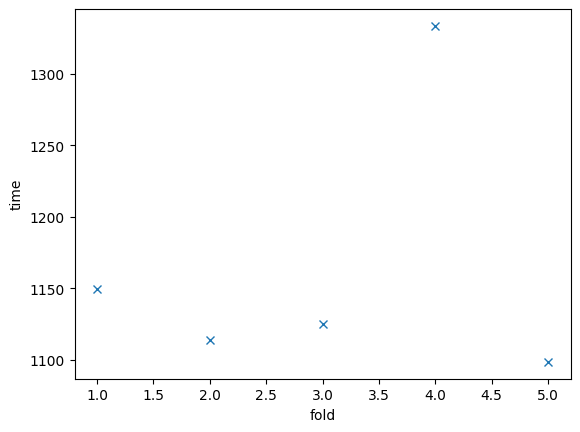

In [28]:
foldNo = [1,2,3,4,5]

plt.plot(foldNo, curr_epoch_duration, marker = 'x', linestyle = 'None')
plt.xlabel('fold')
plt.ylabel('time')

Text(0, 0.5, 'val_accuracy')

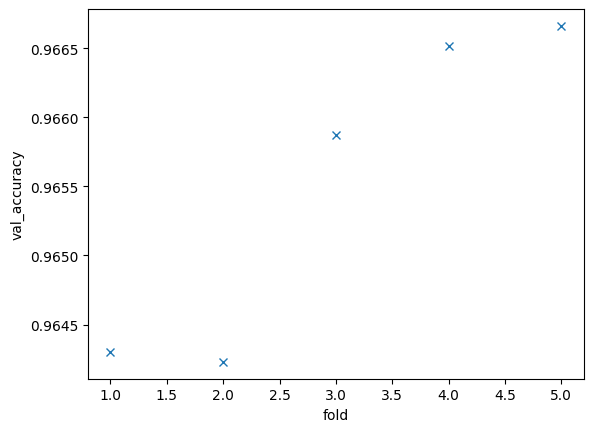

In [29]:
plt.plot(foldNo, curr_val_accuracy, marker = 'x', linestyle = 'None')
plt.xlabel('fold')
plt.ylabel('val_accuracy')

In [30]:
print("durations for 5 folds: ", curr_epoch_duration)
print("val_accuracy for 5 folds: ", curr_val_accuracy)

durations for 5 folds:  [1149.675193786621, 1114.1102702617645, 1124.9141232967377, 1333.5079514980316, 1098.6616854667664]
val_accuracy for 5 folds:  [0.9643036127090454, 0.9642295241355896, 0.965874969959259, 0.9665188193321228, 0.9666618704795837]


### Calculate average duration & val_accuracy for unscaled data

In [41]:
ave_duration = sum(curr_epoch_duration)/5
ave_val_accuracy = sum(curr_val_accuracy)/5
print("average duration for unscaled data: ", ave_duration)
print("average val_accuracy for unscaled data: ", ave_val_accuracy)

average duration for unscaled data:  1164.1738448619842
average val_accuracy for unscaled data:  0.9655177593231201


In [34]:
prediction_accuracy = model_GRU_5fold.predict(X_test)

937/937 [==============================] - 33s 35ms/step


## Confusion matrix for folded dataset

In [35]:
matrix = confusion_matrix(y_test.argmax(axis=1), np.around(prediction_accuracy, decimals=0).argmax(axis=1))

<AxesSubplot: >

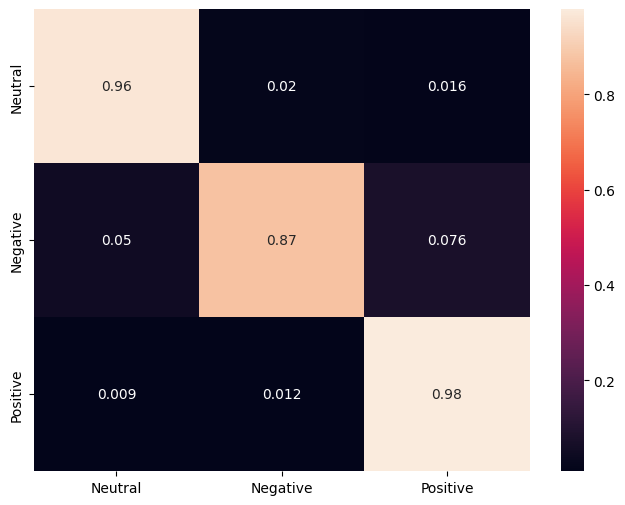

In [36]:
import seaborn as sns
conf_matrix = pd.DataFrame(matrix, index = ['Neutral','Negative','Positive'],columns = ['Neutral','Negative','Positive'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 10})

#### From the plot and average(mean) duration and val_accuracy, we can see that the val_accuracy after k-fold stays approximately the same compared to the unfolded dataset. It could be inferred that the model performs quite well on the overall dataset as well as each fold. We could conclude that this model has a very high accuracy and it is actually a good model.

# Scaling data

#### In neural network, we normally scale down dataset, especially training data, for gradient descent to converge faster. Therefore, we also perform experiment to scale X_train, X_val and X_test to see how well the model performs

In [37]:
def preprocess_dataset(df_train, df_val, df_test):
    standard_scaler = preprocessing.StandardScaler()
    
    df_train_scaled = standard_scaler.fit_transform(df_train)
    df_val_scaled = standard_scaler.transform(df_val)
    df_test_scaled = standard_scaler.transform(df_test)

    return df_train_scaled, df_val_scaled, df_test_scaled

In [45]:
n_split=5
curr_epoch_duration_scaled = []
curr_val_accuracy_scaled = []

for train_index,val_index in KFold(n_split).split(X_train):
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold,y_val_fold = y_train[train_index], y_train[val_index]
    x_train_scaled, x_val_scaled, x_test_scaled = preprocess_dataset(x_train_fold, x_val_fold, X_test)

    start_time=time.time()

    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    model_GRU_5fold_scaled = Sequential()
    model_GRU_5fold_scaled.add(layers.Embedding(max_words, 40, input_length=max_len))
    model_GRU_5fold_scaled.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))
    model_GRU_5fold_scaled.add(layers.Dense(3,activation='softmax'))


    model_GRU_5fold_scaled.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])

    start_time=time.time()
    history = model_GRU_5fold_scaled.fit(x_train_scaled, y_train_fold, 
                              epochs=100,
                              batch_size = 256,
                              validation_data=(x_val_scaled, y_val_fold),
                              callbacks=[stop_early])

    stop_time=time.time()
    duration =stop_time-start_time
    curr_epoch_duration_scaled.append(duration)

    validation = history.history['val_accuracy'][-1]
    curr_val_accuracy_scaled.append(validation)

Epoch 1/100
219/219 [==============================] - 31s 128ms/step - loss: 0.8343 - accuracy: 0.6438 - val_loss: 0.8102 - val_accuracy: 0.6405
Epoch 2/100
219/219 [==============================] - 28s 127ms/step - loss: 0.7889 - accuracy: 0.6615 - val_loss: 0.7976 - val_accuracy: 0.6586
Epoch 3/100
219/219 [==============================] - 27s 126ms/step - loss: 0.7866 - accuracy: 0.6672 - val_loss: 0.7938 - val_accuracy: 0.6620
Epoch 4/100
219/219 [==============================] - 32s 144ms/step - loss: 0.7828 - accuracy: 0.6688 - val_loss: 0.8006 - val_accuracy: 0.6617
Epoch 5/100
219/219 [==============================] - 29s 134ms/step - loss: 0.7814 - accuracy: 0.6689 - val_loss: 0.7925 - val_accuracy: 0.6625
Epoch 6/100
219/219 [==============================] - 29s 132ms/step - loss: 0.7780 - accuracy: 0.6700 - val_loss: 0.8000 - val_accuracy: 0.6625
Epoch 7/100
219/219 [==============================] - 31s 140ms/step - loss: 0.7777 - accuracy: 0.6697 - val_loss: 0.7904 -

Epoch 1/100
219/219 [==============================] - 30s 128ms/step - loss: 0.8435 - accuracy: 0.6354 - val_loss: 0.7919 - val_accuracy: 0.6526
Epoch 2/100
219/219 [==============================] - 28s 126ms/step - loss: 0.7996 - accuracy: 0.6529 - val_loss: 0.7675 - val_accuracy: 0.6756
Epoch 3/100
219/219 [==============================] - 28s 127ms/step - loss: 0.7896 - accuracy: 0.6629 - val_loss: 0.7657 - val_accuracy: 0.6777
Epoch 4/100
219/219 [==============================] - 29s 132ms/step - loss: 0.8050 - accuracy: 0.6627 - val_loss: 0.7646 - val_accuracy: 0.6789
Epoch 5/100
219/219 [==============================] - 29s 131ms/step - loss: 0.7844 - accuracy: 0.6655 - val_loss: 0.7658 - val_accuracy: 0.6790
Epoch 6/100
219/219 [==============================] - 28s 130ms/step - loss: 0.7913 - accuracy: 0.6647 - val_loss: 0.7658 - val_accuracy: 0.6786
Epoch 7/100
219/219 [==============================] - 29s 131ms/step - loss: 0.7828 - accuracy: 0.6667 - val_loss: 0.7619 -

Epoch 19/100
219/219 [==============================] - 30s 138ms/step - loss: 0.7748 - accuracy: 0.6703 - val_loss: 0.7814 - val_accuracy: 0.6656
Epoch 20/100
219/219 [==============================] - 30s 138ms/step - loss: 0.7765 - accuracy: 0.6693 - val_loss: 0.7800 - val_accuracy: 0.6668
Epoch 21/100
219/219 [==============================] - 28s 128ms/step - loss: 0.7746 - accuracy: 0.6699 - val_loss: 0.7817 - val_accuracy: 0.6667
Epoch 22/100
219/219 [==============================] - 28s 128ms/step - loss: 0.7748 - accuracy: 0.6701 - val_loss: 0.7797 - val_accuracy: 0.6674
Epoch 23/100
219/219 [==============================] - 28s 128ms/step - loss: 0.7809 - accuracy: 0.6691 - val_loss: 0.7803 - val_accuracy: 0.6664
Epoch 24/100
219/219 [==============================] - 29s 134ms/step - loss: 0.7744 - accuracy: 0.6701 - val_loss: 0.7809 - val_accuracy: 0.6668
Epoch 25/100
219/219 [==============================] - 29s 130ms/step - loss: 0.7748 - accuracy: 0.6696 - val_loss: 0

### Accuracy & time plot

Text(0, 0.5, 'time')

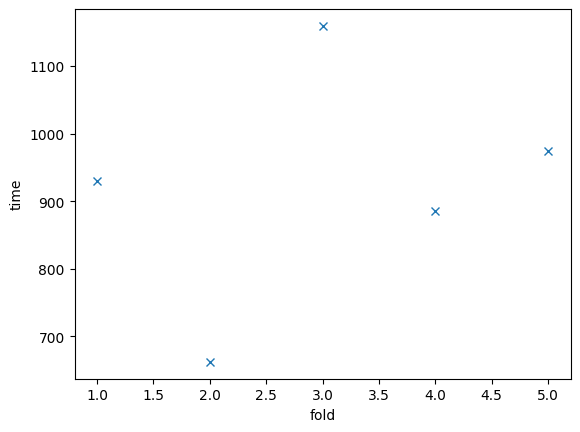

In [39]:
foldNo = [1,2,3,4,5]

plt.plot(foldNo, curr_epoch_duration_scaled, marker = 'x', linestyle = 'None')
plt.xlabel('fold')
plt.ylabel('time')

Text(0, 0.5, 'val_accuracy')

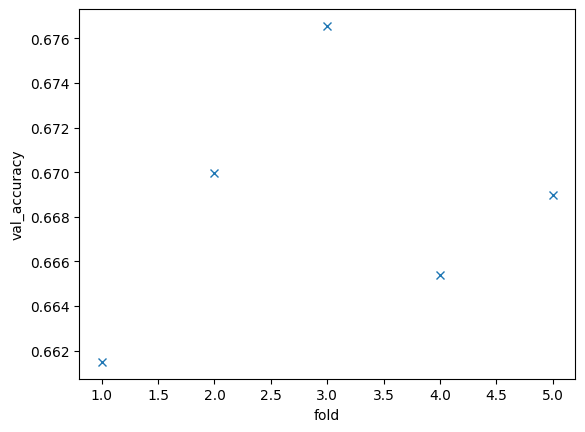

In [40]:
plt.plot(foldNo, curr_val_accuracy_scaled, marker = 'x', linestyle = 'None')
plt.xlabel('fold')
plt.ylabel('val_accuracy')

### Calculate average duration & val_accuracy for unscaled data

In [41]:
print("durations for 5 folds scaled: ", curr_epoch_duration_scaled)
print("val_accuracy for 5 folds scaled: ", curr_val_accuracy_scaled)

durations for 5 folds scaled:  [929.2842533588409, 662.1506264209747, 1159.462097644806, 885.2123749256134, 973.78355884552]
val_accuracy for 5 folds scaled:  [0.6614922285079956, 0.6699814200401306, 0.6765631437301636, 0.6654027700424194, 0.668979823589325]


In [42]:
ave_duration_scaled = sum(curr_epoch_duration_scaled)/5
ave_val_accuracy_scaled = sum(curr_val_accuracy_scaled)/5
print("average duration for scaled data: ", ave_duration_scaled)
print("average val_accuracy for scaled data: ", ave_val_accuracy_scaled)

average duration for scaled data:  921.978582239151
average val_accuracy for scaled data:  0.6684838771820069


#### Time duration to train the model with scaled dataset (922s) is lower than that of unscaled dataset (1165s). However, the validation accuracy of scaled dataset (0.668) is much lower than that of unscaled dataset (0.966). One possible cause could be that our assumption “value distribution fits a Gaussian distribution with a well-behaved mean and standard deviation” does not align with the TikTok dataset. Therefore, scaling may not be an appropriate method to speed up convergence.